In [1]:
import time
import datetime
import numpy as np
import pandas as pd
import lightgbm as lgb
from dateutil.parser import parse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
try:
    import matplotlib.pyplot as plt
except ImportError:
    raise ImportError('You need to install matplotlib for plot_example.py.')

In [9]:
data_path = 'D:/tianchi/diabate/'

# train = pd.read_csv(data_path+'d_train_20180102.csv',encoding='gb2312')
# test = pd.read_csv(data_path+'d_test_A_20180102.csv',encoding='gb2312')


In [3]:
def make_train_set():
    train = pd.read_csv(data_path+'d_train_20180102.csv',encoding='gb2312')
    
    
    ulimit = np.percentile(train[u'血糖'].values, 99.5)
    llimit = np.percentile(train[u'血糖'].values, 0.3)
    print (ulimit, llimit)
    train = train[train[u'血糖'] < ulimit]
    train = train[train[u'血糖'] > llimit]
    
    
    train['性别'] = train['性别'].map(lambda x: '男' if x not in ['男','女'] else x)
    sex_dummy = pd.get_dummies(train["性别"])
    train = pd.concat([train, sex_dummy],axis=1)
    
    train = train.drop(["id","性别","体检日期"],axis=1)
    
    train.fillna(train.median(axis=0),inplace=True)
    
    tarin_y = train['血糖']
    train_x = train.drop(['血糖'],axis=1)
    
    
    
    return train_x,tarin_y

def make_test_set():
    
    test = pd.read_csv(data_path+'d_test_A_20180102.csv',encoding='gb2312')
    test['性别'] = test['性别'].map(lambda x: '男' if x not in ['男','女'] else x)
    sex_dummy = pd.get_dummies(test["性别"])
    test = pd.concat([test, sex_dummy],axis=1)
    
    test = test.drop(["id","性别","体检日期"],axis=1)
    
    test.fillna(test.median(axis=0),inplace=True)
    
    return test



X_train, Y_train = make_train_set()
X_test = make_test_set()
columns = [f for f in X_train.columns]


x_train, x_test, y_train, y_test = train_test_split(X_train.values, Y_train.values, test_size=0.2, random_state=100)    
lgb_train = lgb.Dataset(x_train, y_train)

14.7113 3.98


In [4]:
param = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    'num_leaves': 12,
    #'min_data_in_leaf': 5,
    #'min_sum_hessian_in_leaf': 1e-3,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 10,
    'reg_alpha': 0,
    #'reg_lambda': 100,
    'verbose': 0,
    #'max_bin': 300,

}
print ('cv to find best num_boost_round')
bst = lgb.cv(
    param, lgb_train, num_boost_round=10000, nfold=10, stratified=False, shuffle=True,
    early_stopping_rounds=100, verbose_eval=100, show_stdv=True, seed=100)

print (u'迭代:', len(bst['l2-mean']), u' CV:', bst['l2-mean'][-1])

cv to find best num_boost_round
[100]	cv_agg's l2: 1.399 + 0.165395
[200]	cv_agg's l2: 1.3285 + 0.145669
[300]	cv_agg's l2: 1.29268 + 0.13581
[400]	cv_agg's l2: 1.27984 + 0.134741
[500]	cv_agg's l2: 1.27557 + 0.133367
[600]	cv_agg's l2: 1.27279 + 0.132348
[700]	cv_agg's l2: 1.27183 + 0.130014
迭代: 671  CV: 1.2712622789


Plot feature importances...


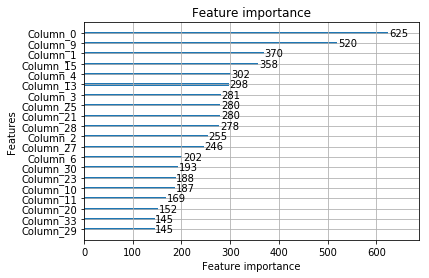

Index(['年龄', '甘油三酯', '*天门冬氨酸氨基转换酶', '尿酸', '*r-谷氨酰基转换酶', '尿素', '*碱性磷酸酶',
       '白细胞计数', '红细胞平均体积', '红细胞体积分布宽度', '*丙氨酸氨基转换酶', '红细胞平均血红蛋白浓度', '白蛋白',
       '血小板平均体积', '血红蛋白', '总胆固醇', '高密度脂蛋白胆固醇', '乙肝核心抗体', '中性粒细胞%', '血小板计数'],
      dtype='object')


In [7]:
# K折预测取平均
gbm = lgb.train(params=param,
                train_set=lgb_train,
                num_boost_round=len(bst['l2-mean']),
                )

print('Plot feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=20)
plt.show()

feat_imp = pd.Series(gbm.feature_importance(), index=columns).sort_values(ascending=False)
print(feat_imp.index[:20])


###这是测试得到的top50 特征，测试代码已省
top_columns = ['年龄/红细胞体积分布宽度', '尿素/高密度脂蛋白胆固醇', '红细胞平均体积/红细胞平均血红蛋白浓度', '红细胞体积分布宽度/血红蛋白',
       '年龄/高密度脂蛋白胆固醇', '*天门冬氨酸氨基转换酶/总胆固醇', '红细胞体积分布宽度/血小板平均体积',
       '总胆固醇/*天门冬氨酸氨基转换酶', '甘油三酯/尿酸', '红细胞平均体积/血小板平均体积',
       '*丙氨酸氨基转换酶/*天门冬氨酸氨基转换酶', '白细胞计数/红细胞体积分布宽度', '年龄/血小板计数', '尿酸/血红蛋白',
       '尿酸/*碱性磷酸酶', '甘油三酯/*天门冬氨酸氨基转换酶', '年龄/*天门冬氨酸氨基转换酶', '红细胞平均体积/乙肝核心抗体',
       '红细胞体积分布宽度/年龄', '*碱性磷酸酶/红细胞平均体积', '*天门冬氨酸氨基转换酶/*丙氨酸氨基转换酶',
       '红细胞平均血红蛋白浓度/红细胞平均体积', '红细胞体积分布宽度/总胆固醇', '红细胞平均体积/年龄', '白细胞计数/血小板计数',
       '红细胞体积分布宽度/白蛋白', '红细胞平均体积/血红蛋白', '尿素/红细胞平均体积', '*碱性磷酸酶/高密度脂蛋白胆固醇',
       '红细胞体积分布宽度/红细胞平均血红蛋白浓度', '甘油三酯/血小板计数', '尿酸/血小板平均体积', '尿素/红细胞体积分布宽度',
       '*天门冬氨酸氨基转换酶/*碱性磷酸酶', '高密度脂蛋白胆固醇/年龄', '高密度脂蛋白胆固醇/中性粒细胞%',
       '血红蛋白/高密度脂蛋白胆固醇', '白蛋白/血红蛋白', '*碱性磷酸酶/总胆固醇', '年龄/尿酸', '尿酸/白细胞计数',
       '总胆固醇/年龄', '年龄/红细胞平均体积', '*天门冬氨酸氨基转换酶/白细胞计数', '红细胞体积分布宽度/白细胞计数',
       '尿素/尿酸', '血红蛋白/红细胞平均体积', '血红蛋白/血小板计数', '尿酸/总胆固醇', '红细胞体积分布宽度/尿素']

for i in feat_imp.index[:20]:
    for j in feat_imp.index[:20] :
        if j!=i:
            divide = i+"/"+j
            if divide in top_columns:
                X_train[divide] = X_train[i]/X_train[j]
                X_test[divide] = X_test[i]/X_test[j]
                
##是否保留原始特征
# X_train  = X_train.drop(columns,axis=1)
# X_test  = X_test.drop(columns,axis=1)


train_divide = pd.concat([X_train, Y_train],axis=1)
train_divide.to_csv('./train_divide.csv',index=False)
X_test.to_csv('./test_divide.csv',index=False)


